# Optimizing a simple linear regression model

## Generating training data
We will take the case of a simple linear function $y_i = x_i + \mathcal{N}(0, 1)$.  We will attempt to optimize a model of the form $\hat{y} = w x + b$, and expect to find $w \approx 1, b \approx 0$.

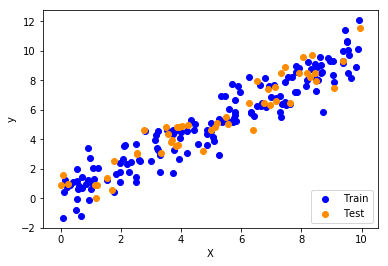

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

n_trials = 200
X = 10 * np.random.rand(n_trials)  # random floats on the interval [0, 10]
noise = np.random.normal(0, 1, n_trials)
y_true = X + noise

X_train = X[:150]
y_train = y_true[:150]

X_test = X[150:]
y_test = y_true[150:]

fig = plt.figure()
plt.scatter(X_train, y_train, color='blue', label='Train')
plt.scatter(X_test, y_test, color='darkorange', label='Test')
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc='lower right')
plt.show()

## Stochastic gradient descent

After initializing $w$ and $b$ with random values, we will use stochastic gradient descent (updates after every training example) to update the weights.  The update rule for the weights during training is given by: 
\begin{align}
b &\rightarrow b - \alpha \frac{\partial L}{\partial b},\\
w &\rightarrow w - \alpha \frac{\partial L}{\partial w},
\end{align}

where the learning rate $\alpha$ is a hyperparameter we must set by hand.  We will minimize the mean squared error (MSE) loss, $L(y, \hat{y}) = \frac{1}{2}(y - \hat{y})^2$.  After rewriting the model predicted value $\hat{y}$ in terms of the parameters, we have:
\begin{align}
\frac{\partial L}{\partial b} &= w x + b - y, \\
\frac{\partial L}{\partial w} &= x(w x + b - y)
\end{align}

In [3]:
import random


def compute_example_loss(y_true: float, y_predicted: float) -> float:
    return 0.5 * (y_true - y_predicted)**2


def compute_model_prediction(w: float, b: float, x: float) -> float:
    return w * x + b


def run_one_epoch(x_training, y_training, w, b, alpha):
    epoch_loss = 0
    for x, y_true in zip(x_training, y_training):
        y_pred = w*x + b
        example_loss = compute_example_loss(y_true, y_pred)
        epoch_loss += example_loss
        b -= alpha * (w*x + b - y_true)
        w -= alpha * x * (w*x + b - y_true)
    return w, b, epoch_loss


def evaluate_model(w, b):
    y_preds = w * X_test + b * np.ones_like(X_test)
    diffs = y_preds - y_test
    avg_mse = 0.5 * np.mean(diffs * diffs)
    return avg_mse


def train_model(alpha: float, epochs: int = 5): 
    w = random.random()
    b = random.random()
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs+1):
        w, b, epoch_loss = run_one_epoch(x_training=X_train, y_training=y_train, 
                                         w=w, b=b, alpha=alpha)
        train_losses.append(epoch_loss)
        test_loss = evaluate_model(w, b)
        test_losses.append(test_loss)
    return w, b, train_losses, test_losses


w, b, train_losses, test_losses = train_model(alpha=0.01, epochs=5)
print("w: {0}".format(w))
print("b: {0}".format(b))
print("Training losses: {0}".format(train_losses))
print("Test set losses: {0}".format(test_losses))    



w: 1.0460491343966316
b: -0.05455659612695463
Training losses: [106.26379395127529, 98.04241943218548, 94.41519758135432, 92.63243918187382, 91.75761936411449]
Test set losses: [0.53156430578731, 0.5088170249166436, 0.49954442116941544, 0.49633902346637226, 0.49571924624089336]


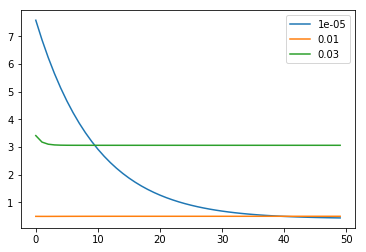

In [4]:
def train_multiple_models(alphas):
    results = {}
    for alpha in alphas:
        _, _, _, losses = train_model(alpha, epochs=50)
        results[alpha] = losses
    return results
        

losses_by_learning_rate = train_multiple_models([0.00001, 0.01, 0.03])
plt.figure()
for lr, losses in losses_by_learning_rate.items():
    plt.plot(losses, label=str(lr))
plt.legend(loc='upper right')
plt.show()

## Minibatch SGD

The main difference in the update rule between minibatch SGD and SGD is that the loss is computed as the sum of individual example losses for all $m$ examples in the batch:
\begin{align}
L(\hat{y}, y) &= \frac{1}{2m}\sum_i^m(\hat{y_i} - y_i)^2
\end{align}

The derivatives become:
\begin{align}
\frac{\partial L}{\partial b} &= \frac{1}{m}\sum_i^m(b + wx_i - y_i), \\
\frac{\partial L}{\partial w} &= \frac{1}{m}\sum_i^m x_i (b + wx_i - y_i)
\end{align}

Writing the code to write the minibatch SGD equivalent of the above SGD example is left as an exercise.

## Linear regression with PyTorch

In practice, we will rarely need to implement a gradient-based optimization algorithm ourselves, as this is typically handled very well by off-the-shelf implementations.  PyTorch is a Python library which is very useful for implementing deep learning models.  A linear regression model will serve as a simple introduction to PyTorch.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class LinearRegressor(nn.Module):
    
    def __init__(self):
        self.linear_layer = nn.Linear(1, 1, bias=True)
    
    def forward(self, X: np.array):
        return self.linear_layer(X)
    

def train_one_batch(model: LinearRegressor, batch_X: np.array, batch_y: np.array):
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loss_func = nn.MSELoss()
    y_preds = model(batch_X)
    loss = loss_func(y_preds, batch_y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

        

The code for running training epochs and obtaining model outputs is very similar to the above, and is left as an exercise.